# import packages

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import root_mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data",os.listdir(os.path.join(os.path.dirname(os.getcwd()),"data"))[0])

with zipfile.ZipFile(data_path) as z:
    with z.open("sample_submission.csv") as f:
        sample_submission = pd.read_csv(f)
    with z.open("test.csv") as f:
        test = pd.read_csv(f)
    with z.open("train.csv") as f:
        train = pd.read_csv(f)

In [3]:
train.shape,test.shape

((750000, 9), (250000, 8))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [5]:
train.head(2)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0


In [6]:
def get_dtypes(df):
    cols = list(df.columns)
    object_features, numerical_features = [], []
    datatypes = df.dtypes.to_dict()
    object_features = [column for column in cols if datatypes[column].name=='object']
    numerical_features = [column for column in cols if column not in object_features ]
    return object_features,numerical_features
   

In [7]:
object_features, numerical_features = get_dtypes(train)

In [31]:
object_features

['Sex']

In [8]:
train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [32]:
train["Sex"].value_counts()

Sex
female    375721
male      374279
Name: count, dtype: int64

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Duration'}>,
        <Axes: title={'center': 'Heart_Rate'}>],
       [<Axes: title={'center': 'Body_Temp'}>,
        <Axes: title={'center': 'Calories'}>, <Axes: >]], dtype=object)

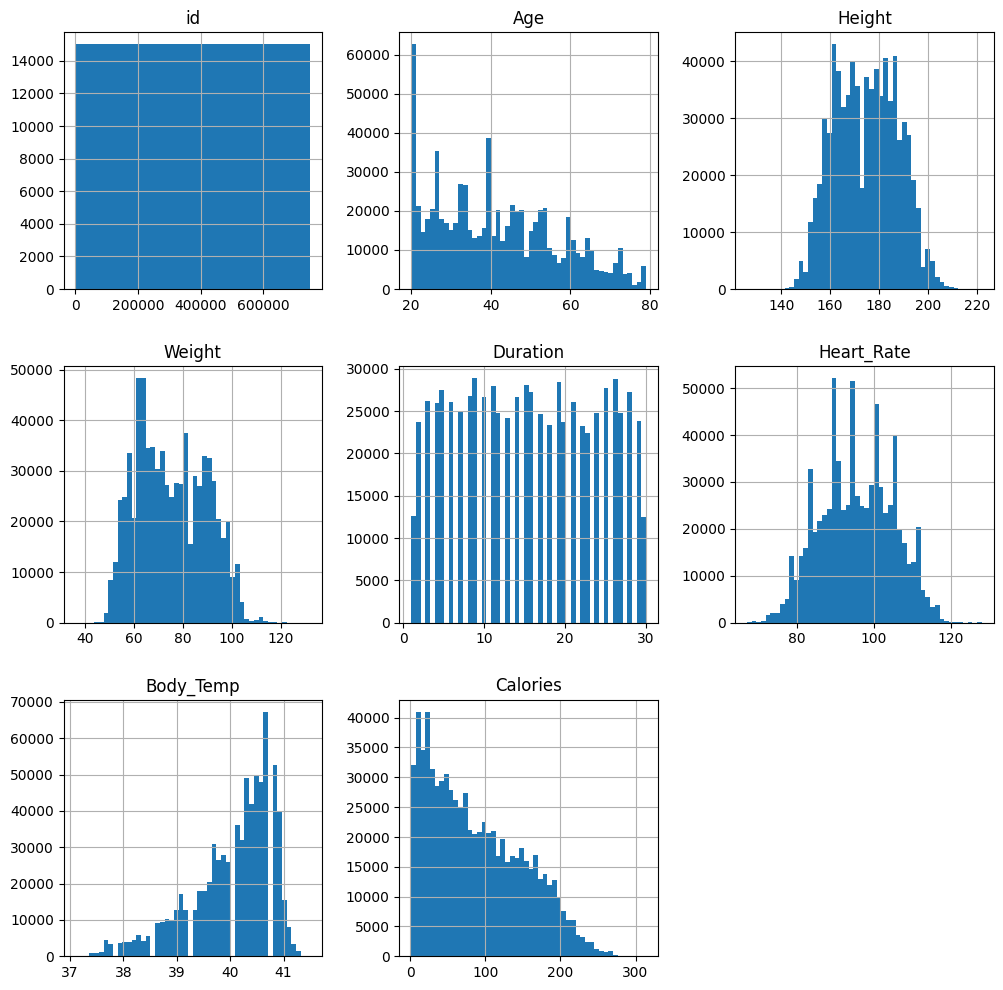

In [9]:
train.hist(bins=50, figsize=(12, 12))

In [10]:
bins = [-np.inf,80,90,100,110,np.inf]
labels = [0,1,2,3,4]
train["hr_category"] = pd.cut(train["Heart_Rate"],
                               bins=bins,
                               labels=labels)


In [11]:
train_set, test_set = train_test_split(
    train, test_size=0.2, stratify=train[["hr_category"]], random_state=42)

In [12]:
train_set.shape, test_set.shape, 

((600000, 10), (150000, 10))

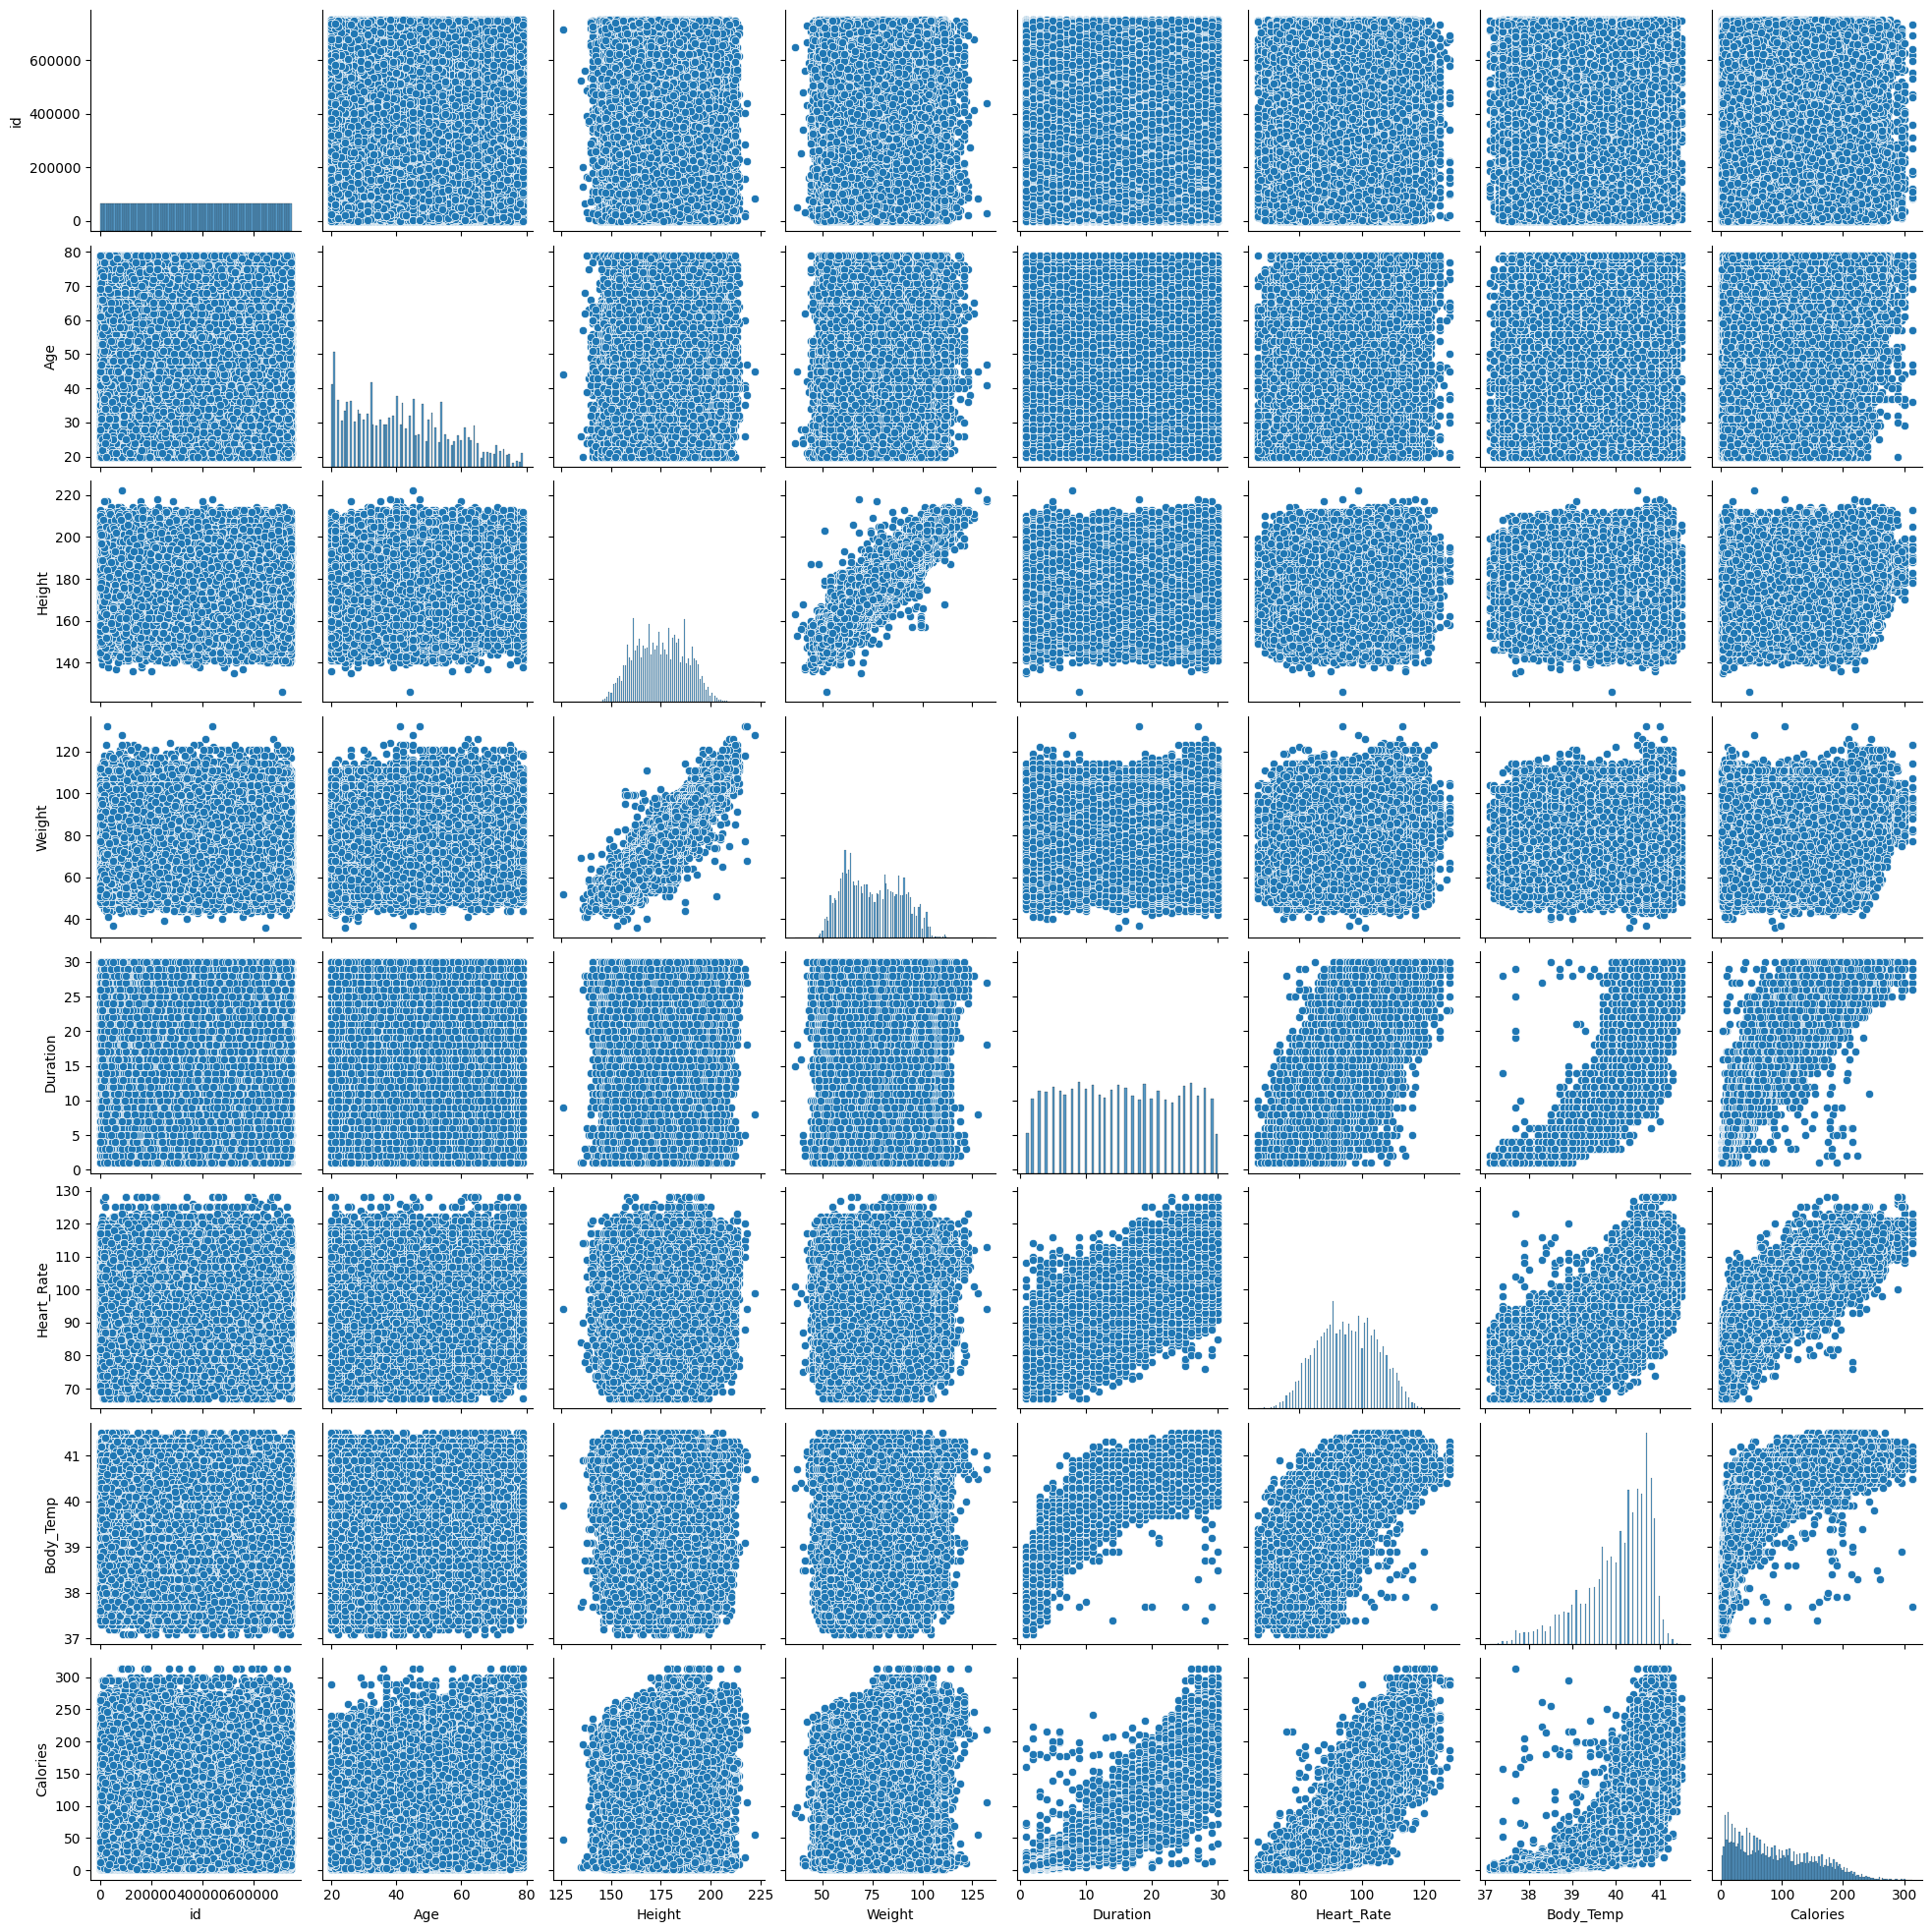

In [13]:
sns.pairplot(train_set)

In [14]:
train_set.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'Calories', 'hr_category'],
      dtype='object')

In [15]:
target = "Calories"

<Axes: xlabel='Heart_Rate', ylabel='Calories'>

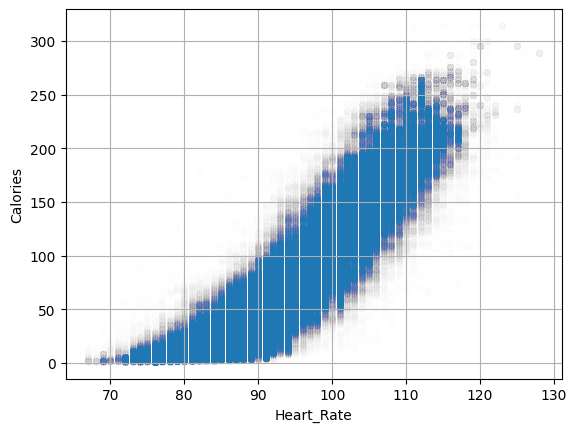

In [16]:
train_set.plot(kind="scatter", x="Heart_Rate", y=target, grid=True, alpha=0.005)

In [17]:
# Heart_Rate is relevant

<Axes: xlabel='Age', ylabel='Calories'>

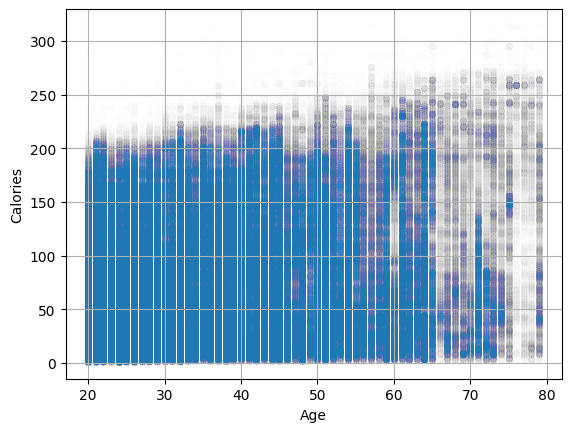

In [18]:
train_set.plot(kind="scatter", x="Age", y=target, grid=True, alpha=0.005)

In [19]:
# Age is relevant

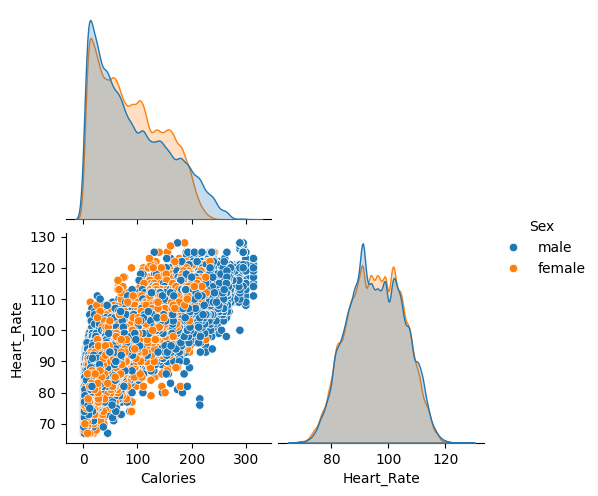

In [20]:
sns.pairplot(train_set[[target,"Heart_Rate","Sex"]], hue="Sex",corner=True)

In [21]:
# Sex is relevant

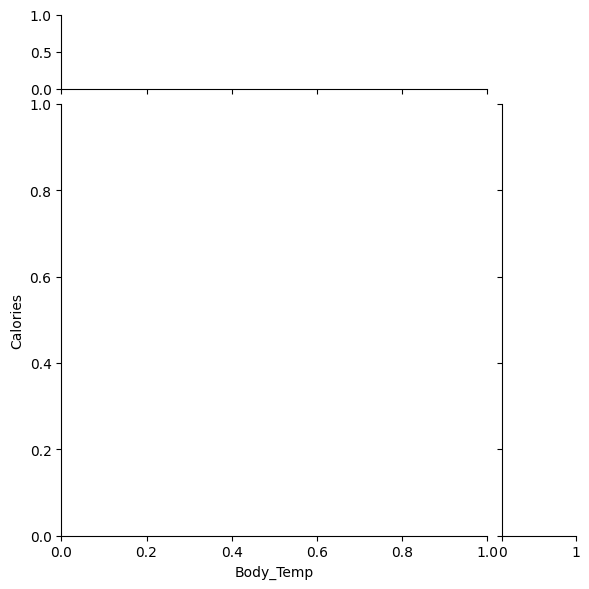

In [22]:
sns.JointGrid(data=train_set, x="Body_Temp", y=target, marginal_ticks=True)

# new features

In [23]:
train_set["heart_rate_duration"] = train_set["Heart_Rate"]*train_set["Duration"]

<Axes: xlabel='heart_rate_duration', ylabel='Calories'>

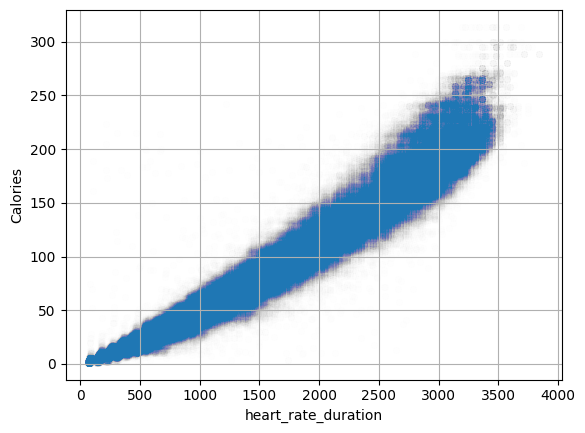

In [24]:
train_set.plot(kind="scatter", x="heart_rate_duration", y=target, grid=True, alpha=0.005)

<Axes: xlabel='heart_rate_duration', ylabel='Calories'>

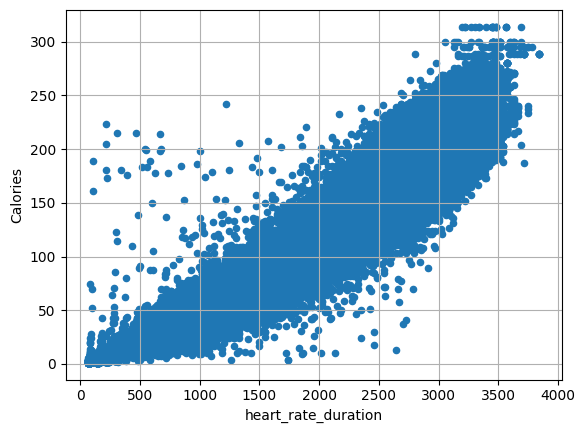

In [25]:
train_set.plot(kind="scatter", x="heart_rate_duration", y=target, grid=True,)

In [26]:
lin_reg = LinearRegression(fit_intercept=False)

In [27]:
linear_rmsles = cross_val_score(lin_reg, train_set["heart_rate_duration"].values.reshape(-1,1), train_set[target].values,
                              scoring="neg_root_mean_squared_log_error", cv=10)

In [28]:
linear_rmsles.mean()

np.float64(-0.23490137427005564)

In [29]:
linear_results = cross_validate(lin_reg, train_set["heart_rate_duration"].values.reshape(-1,1), train_set[target].values,
                              scoring="neg_root_mean_squared_log_error", cv=10,return_train_score=True)

In [30]:
linear_results

{'fit_time': array([0.01318288, 0.01245451, 0.0101099 , 0.01047802, 0.01059151,
        0.01081204, 0.00998569, 0.01012635, 0.01063108, 0.01347947]),
 'score_time': array([0.0015018 , 0.00133419, 0.00141931, 0.00130916, 0.00129175,
        0.00128317, 0.00130463, 0.00126576, 0.0014832 , 0.00216413]),
 'test_score': array([-0.23476523, -0.23443704, -0.23556872, -0.23583984, -0.23665507,
        -0.23393126, -0.23453062, -0.23354289, -0.23536604, -0.23437703]),
 'train_score': array([-0.23490474, -0.23501975, -0.23484049, -0.23481943, -0.23464089,
        -0.23501738, -0.2349343 , -0.23508299, -0.23481411, -0.2349571 ])}